# Masking


In [1]:

import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from skimage import color
from scipy.spatial import ConvexHull
from PIL import Image
import os.path



def read_obj(in_file):
    '''
    Reads out the vertices and uvs from an obj file.

            Parameters:
                    in_file (String): The path to the obj file

            Returns:
                    obj ][[[float, float, float],..],[[float float],..],[[[float, float, float], ...],...]]): An objects with three lists, 
                        first containing three float arrays for xyz coordinate of the vertices, 
                        second containingng two float arrays for uv1 and uv2,
                        thirs containing three arrays of three float arrays for triangle values

    '''

    vertices = []
    uvs = []
    triangles = []

    file = open(in_file, 'r')
    Lines = file.readlines()
  
    # Strips the newline character
    for line in Lines:
        if(line.startswith('v ')):
            vertexData = line.split(' ')
            vertices.append([float(vertexData[1]), float(vertexData[2]), float(vertexData[3])])
        
        if(line.startswith('vt ')):
            textureData = line.split(' ')            
            if(float(textureData[1]) > 1):
                textureData[1] = "1"  
            if(float(textureData[2]) > 1):
                textureData[2] = "1"
            uvs.append([float(textureData[1]), float(textureData[2])])

        if(line.startswith('f ')):
            textureData = line.split(' ')
            exctracted = []
            exctracted.append(np.array(textureData[1].split('/'), np.int32))
            exctracted.append(np.array(textureData[2].split('/'), np.int32))
            exctracted.append(np.array(textureData[3].split('/'), np.int32))
            triangles.append(exctracted)

    return [vertices, uvs, triangles]


def getMask(obj, image, colored):
    maskedImage = np.zeros([len(image), len(image[0]), 3],dtype=np.uint8)

    for triangle in obj[2]:
        uv1 = obj[1][triangle[0][1] - 1]
        uv2 = obj[1][triangle[1][1] - 1]
        uv3 = obj[1][triangle[2][1] - 1]
        
        allTexels = getAllTexels(uv1, uv2, uv3, image, colored)

        for texel6DPoint in allTexels:

            texelColor = [texel6DPoint[2],texel6DPoint[3],texel6DPoint[4]]

            xpos = len(image) - round(texel6DPoint[1] * len(image)) - 1
            ypos = round(texel6DPoint[0] * len(image[0])) - 1
            
            maskedImage[xpos, ypos] = [texelColor[0],texelColor[1],texelColor[2]]


    # Image Plotting
    plt.imshow(maskedImage)
    plt.show()
    return maskedImage


def getAllTexels(p1, p2, p3, image, colored): #RGBXYZXY
    p1X = round(p1[0] * len(image[0])) 
    p1Y = len(image) -  round(p1[1] * len(image))  
    p2X = round(p2[0] * len(image[0])) 
    p2Y = len(image) -  round(p2[1] * len(image))  
    p3X = round(p3[0] * len(image[0])) 
    p3Y = len(image) -  round(p3[1] * len(image))  

    minX = min(p1X, min(p2X, p3X))
    maxX = max(p1X, max(p2X, p3X))
    minY = min(p1Y, min(p2Y, p3Y))
    maxY = max(p1Y, max(p2Y, p3Y))  

    allTexels = []

    for x in range(maxX - minX):
        for y in range(maxY - minY):
            currentPointX = minX + x
            currentPointY = minY + y
            #https://codeplea.com/triangular-interpolation
            denom = ((p2Y - p3Y) * (p1X - p3X) + (p3X - p2X) * (p1Y - p3Y))

            if(denom != 0):
                weightP1 = ((p2Y - p3Y) * (currentPointX - p3X) + (p3X - p2X) * (currentPointY - p3Y) ) / denom
                weightP2 = ((p3Y - p1Y) * (currentPointX - p3X) + (p1X - p3X) * (currentPointY - p3Y) ) / denom
                weightP3 = 1 - weightP1 - weightP2


                if(not (weightP1 < -0.1 or weightP2 < -0.1 or weightP3 < -0.1)): # with this you could check if the point is inside the triangle
                    if(colored):
                        currentPointCol = [image[currentPointY][currentPointX][0], #R
                                            image[currentPointY][currentPointX][1], #G
                                            image[currentPointY][currentPointX][2]] #B 
                    else:
                        currentPointCol = [255,255,255]

                        
                    texel = [currentPointX/len(image[0]), (len(image) -currentPointY)/len(image), currentPointCol[0], currentPointCol[1], currentPointCol[2]]
                    allTexels.append(texel)
            
    return allTexels


Multiple masking

In [15]:
def maskedAllImages( path, firstValue, numberOfCountDigits, colored = False):
    counter = firstValue

    lastExisted = True
    while (lastExisted):
        digitsOfNumber = len(str(counter))
        zeros = ""
        for i in range(numberOfCountDigits - digitsOfNumber):
            zeros += "0"

        assembledObjPath = path + zeros + str(counter) + "_fused_mesh.obj"
        assembledTexturePath = path + zeros + str(counter) + "_texture.png"
        print(assembledObjPath)
        print(assembledTexturePath)

        textureName =  zeros + str(counter) + "_texture.png"
        if(os.path.isfile(assembledObjPath) and os.path.isfile(assembledTexturePath)):
            texture = cv2.cvtColor(cv2.imread(assembledTexturePath, ), cv2.COLOR_BGR2RGB)
            obj = read_obj(assembledObjPath)
            coloredImage = getMask(obj, texture, colored)
            im = Image.fromarray(coloredImage)
            im.save('out/' + textureName , format="png")
        else:
            lastExisted = False
        counter += 1

Execution

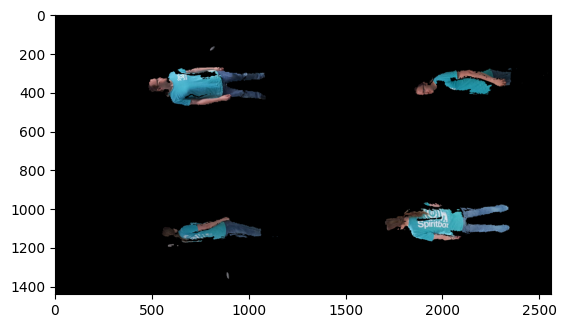

In [2]:
# Run below code for masking multiple files
# maskedAllImages('../../../Unity Project/Avatar_Player/Assets/Resources/Avatar_Sequence/', 1673, 7, False)

# Run below code for single masking
texture = cv2.cvtColor(cv2.imread("../../../Unity Project/Avatar_Player/Assets/Resources/Avatar_Sequence/0001673_texture.png", ), cv2.COLOR_BGR2RGB)
obj = read_obj('../../../Unity Project/Avatar_Player/Assets/Resources/Avatar_Sequence/0001673_fused_mesh.obj')
colored = True
coloredImage = getMask(obj, texture, colored)
im = Image.fromarray(coloredImage)
im.save('masked_images/0001673_texture_2.png' , format="png")